In [1]:
%matplotlib inline

import os
import sys
if sys.version_info < (3,):
    from urllib import urlretrieve
else:
    from urllib.request import urlretrieve
from collections import OrderedDict

import pandas as pd
import matplotlib.pyplot as plt

LMASK = 'https://ldas.gsfc.nasa.gov/gldas/data/0.25deg/landmask_mod44w_025.asc'
LMASK_CSV = LMASK.rpartition('/')[2]
LMASK_FORMAT = {
    'encoding': 'ascii',
    'delim_whitespace': True,
    'header': None,
    'names': ['col', 'row', 'latitude', 'longitude', 'land'],
    'index_col': ['col', 'row'],
    'dtype': {'land': bool},
}

if not os.path.exists(LMASK_CSV):
    urlretrieve(LMASK, LMASK_CSV)

lm = pd.read_csv(LMASK_CSV, **LMASK_FORMAT)
lm.info()
assert lm.index.is_unique

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 864000 entries, (1, 1) to (1440, 600)
Data columns (total 3 columns):
latitude     864000 non-null float64
longitude    864000 non-null float64
land         864000 non-null bool
dtypes: bool(1), float64(2)
memory usage: 17.3 MB


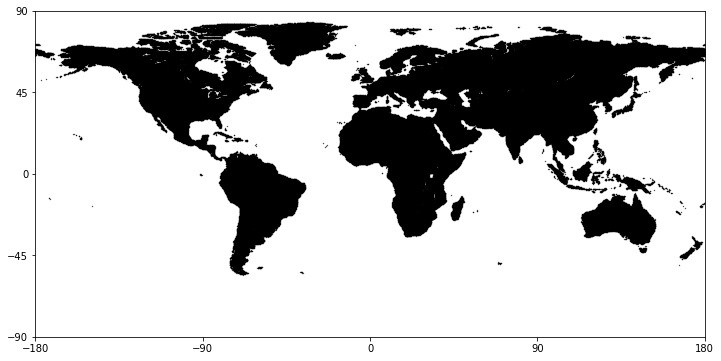

In [2]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis([-180, 180, -90, 90])
ax.set_xticks(range(-180, 181, 90))
ax.set_yticks(range(-90, 91, 45))
ax.scatter('longitude', 'latitude', .1, color='k', data=lm[lm['land']]);

In [3]:
FACTOR = 16

lm['lat'] = pd.cut(lm['latitude'], lm['latitude'].nunique() / FACTOR)
lm['lon'] = pd.cut(lm['longitude'], lm['longitude'].nunique() / FACTOR)

lmx = lm.groupby(['lat', 'lon'])\
    .agg(OrderedDict([('latitude', 'min'), ('longitude', 'min'), ('land', 'any')]))\
    .reset_index(drop=True)
lmx.head()

,latitude,longitude,land
0,-59.875,-179.875,False
1,-59.875,-175.875,False
2,-59.875,-171.875,False
3,-59.875,-167.875,False
4,-59.875,-163.875,False


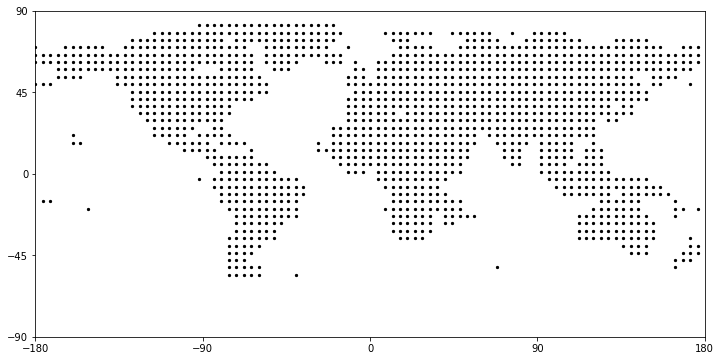

In [4]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis([-180, 180, -90, 90])
ax.set_xticks(range(-180, 181, 90))
ax.set_yticks(range(-90, 91, 45))
ax.scatter('longitude', 'latitude', 5, color='k', data=lmx[lmx['land']]);

In [5]:
import sqlalchemy as sa

engine = sa.create_engine('postgresql://postgres@/glottolog3.0')

query = '''SELECT l.id, l.name, l.latitude, l.longitude, m.name AS macroarea, ll.level
FROM language AS l JOIN languoid AS ll USING (pk)
LEFT JOIN (languoidmacroarea AS lm JOIN macroarea AS m
  ON lm.macroarea_pk = m.pk
) ON lm.languoid_pk = ll.pk
WHERE l.latitude IS NOT NULL ORDER BY id'''

df = pd.read_sql_query(query, engine, index_col='id')
df.info()
assert df.index.is_unique

<class 'pandas.core.frame.DataFrame'>
Index: 7787 entries, aari1239 to zyph1238
Data columns (total 5 columns):
name         7787 non-null object
latitude     7787 non-null float64
longitude    7787 non-null float64
macroarea    7734 non-null object
level        7787 non-null object
dtypes: float64(2), object(3)
memory usage: 365.0+ KB


In [6]:
x = df[['latitude', 'longitude']].reset_index()

lats = lmx['latitude'].unique()
lons = lmx['longitude'].unique()

x['latitude'] = pd.cut(x['latitude'], lats, labels=lats[:-1]).astype(float)
x['longitude'] = pd.cut(x['longitude'], lons, labels=lons[:-1]).astype(float)

x = x.merge(lmx, how='left', on=['latitude', 'longitude']).set_index('id')
x.head()

,latitude,longitude,land
id,,,
aari1239,5.125,36.125,True
aasa1238,-7.125,36.125,True
abad1241,-11.125,144.125,True
abag1245,-7.125,144.125,True
abai1240,5.125,116.125,True


In [7]:
df['land'] = x['land'].fillna(True)
df['land'].value_counts().to_frame().T

,True,False
land,7702,85


In [8]:
df.loc[~df['land'], 'macroarea'].value_counts().to_frame('water').T

,Papunesia,Eurasia,North America,Africa
water,69,12,3,1


In [9]:
df.query('~land & macroarea == "Eurasia"')

,name,latitude,longitude,macroarea,level,land
id,,,,,,
cent2126,Central Okinawan,26.148540,127.781600,Eurasia,language,False
chin1253,Chinese Pidgin English,-0.532240,166.926000,Eurasia,language,False
dhiv1236,Dhivehi,1.928498,73.544330,Eurasia,language,False
kika1239,Kikai,28.310000,129.982000,Eurasia,language,False
kuni1268,Kunigami,26.591100,128.068000,Eurasia,language,False
kuri1271,Kuril Ainu,49.401648,154.722412,Eurasia,language,False
miya1259,Miyako,24.756400,125.363000,Eurasia,language,False
nort2935,Northern Amami-Oshima,28.209900,129.453000,Eurasia,language,False
okin1246,Oki-No-Erabu,27.373800,128.619000,Eurasia,language,False


In [10]:
df.query('~land & macroarea in ("Africa", "North America")')

,name,latitude,longitude,macroarea,level,land
id,,,,,,
baja1265,Bajan,13.13650,-59.53460,North America,language,False
sese1246,Seselwa Creole French,-4.62314,55.45030,Africa,language,False
turk1310,Turks And Caicos Creole English,21.80780,-71.74510,North America,language,False
virg1240,Virgin Islands Creole English,18.04715,-63.07851,North America,language,False


In [11]:
df.query('~land & macroarea == "Papunesia"')

,name,latitude,longitude,macroarea,level,land
id,,,,,,
anei1239,Aneityum,-20.186400,169.825000,Papunesia,language,False
anut1237,Anuta,-11.610000,169.850000,Papunesia,language,False
aust1304,Austral,-23.384300,-149.462000,Papunesia,language,False
ayiw1239,Ayiwo,-10.282595,166.328715,Papunesia,language,False
caro1242,Carolinian,15.205000,145.765000,Papunesia,language,False
cent2058,Central Maewo,-15.078400,168.135000,Papunesia,language,False
cham1312,Chamorro,15.233333,145.750000,Papunesia,language,False
chuu1238,Chuukese,7.340830,151.596000,Papunesia,language,False
coco1260,Cocos Islands Malay,-12.193342,96.833679,Papunesia,language,False
